# 从0开始的RNN建模----隐状态
**隐状态（hidden state）**， 也称为**隐藏变量（hidden variable）**， 它存储了到时间步t-1的序列信息。 通常，我们可以基于当前输入$x_t$和先前隐状态$h_{t-1}$来计算时间步处的任何时间的隐状态$h_t$:  
$$h_t = f(x_{t}, h_{t-1}).$$  
回想一下，我们在 4节中 讨论过的具有隐藏单元的隐藏层。 值得注意的是，隐藏层和隐状态指的是两个截然不同的概念。 如上所述，隐藏层是在从输入到输出的路径上（以观测角度来理解）的隐藏的层， 而隐状态则是在给定步骤所做的任何事情（以技术角度来定义）的输入， 并且这些状态只能通过先前时间步的数据来计算。  
**循环神经网络（recurrent neural networks，RNNs）** 是具有隐状态的神经网络。 

## MLP模型回顾
以单隐含层感知机为例，假设一个小批量样本为$\mathbf{X} \in \mathbb{R}^{n \times d}$，其中批量大小为n，输入维度为d。则隐含层变量$\mathbf{H} \in \mathbb{R}^{n \times h}$计算方法是$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$  
其中隐藏层权重参数为$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$。偏置参数为$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$. 据此，接着求取输出$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q,$. 其中$\mathbf{O} \in \mathbb{R}^{n \times q}$是输出变量，$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$是权重参数，$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$是输出偏置。  
 如果是分类问题，我们可以用$\text{softmax}(\mathbf{O})$来计算输出类别的概率分布。  

## 加入隐含变量
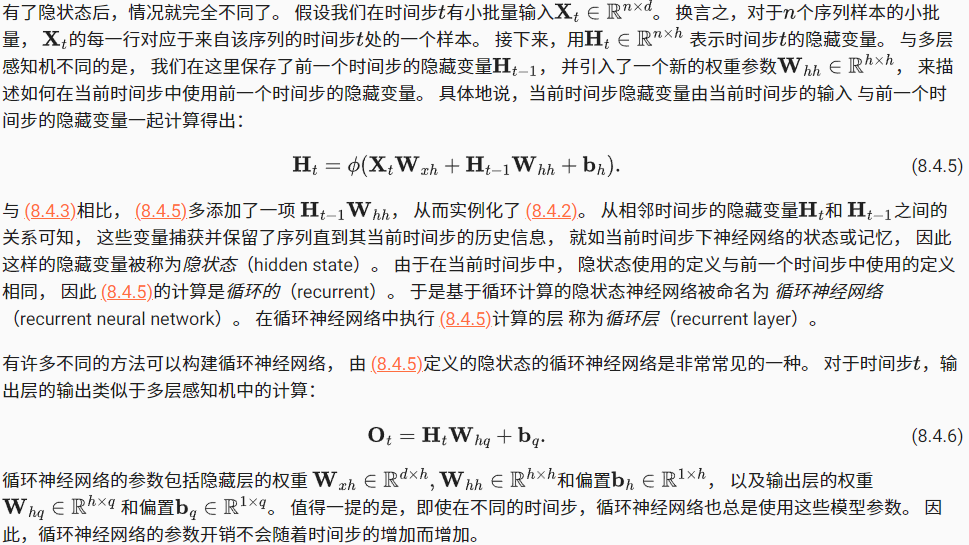
如下图所示展示了上述循环神经网络的结构，其中的节点按时间步分开了，但其实都表示同一个节点，只不过其中的隐状态是随时间步变化的。另外，数学上可以证明：加入隐变量的$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$计算相当于$\mathbf{X}_t$与$\mathbf{H}_{t-1}$的拼接和$\mathbf{W}_{xh}$与$\mathbf{W}_{hh}$的拼接的矩阵乘积
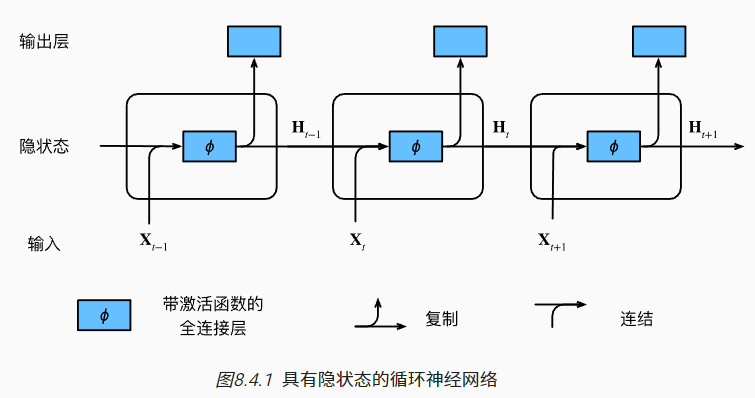

In [1]:
import torch
# X(n, d) = (4, 3), W_xh(d, h) = (3, 2), H(n, h), W_hh(h, h)
X, W_xh = torch.normal(0, 1, (4, 3)), torch.normal(0, 1, (3, 2))
H, W_hh = torch.normal(0, 1, (4, 2)), torch.normal(0, 1, (2, 2))

In [2]:
X@W_xh+H@W_hh

tensor([[-1.9872, -2.4760],
        [-4.0550, -2.3608],
        [-3.5750, -1.9916],
        [-0.7829, -1.4815]])

In [3]:
XH = torch.cat([X, H], 1)  # [X, H] (n, d+h) (4, 5)
W = torch.cat([W_xh, W_hh], 0)  # [[W_xh], [W_hh]] (d+h, h) (5, 2)
XH@W

tensor([[-1.9872, -2.4760],
        [-4.0550, -2.3608],
        [-3.5750, -1.9916],
        [-0.7829, -1.4815]])

## 基于循环神经网络的字符级语言模型
为了简化后续部分的训练，我们考虑使用 字符级语言模型（character-level language model）， 将文本词元化为字符而不是单词。 图8.4.2演示了 如何通过基于字符级语言建模的循环神经网络， 使用当前的和先前的字符预测下一个字符。
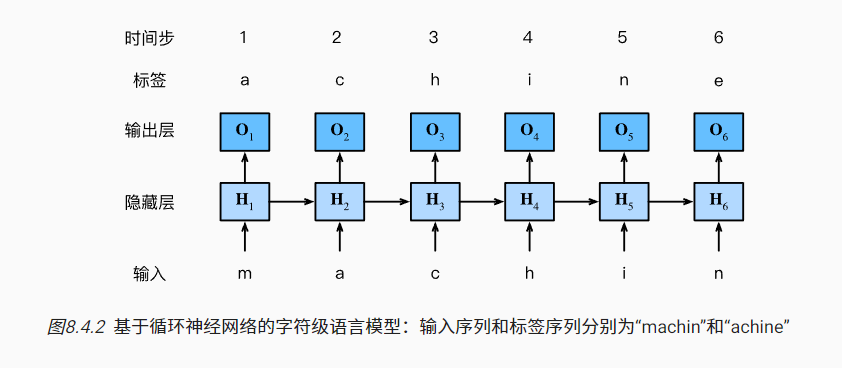
在训练过程中，我们对每个时间步的输出层的输出进行softmax操作， 然后利用交叉熵损失计算模型输出和标签之间的误差。

## 困惑度(Perplexity)
### 交叉熵损失(Cross Entropy Loss)
考虑分类问题，假设标签为$y$，预测值为$\hat{\mathbf{y}}$  
$$l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j.$$  
这里标签$y$是一个独热向量，类似于$(0, ..., 1, ..., 0)$，因此假设实际分类是第i类，则损失l为$-\log \hat{y}_j$，当预测值$\hat{y}_j$也即预测分类属于第i类的概率接近1时l接近0，否则接近正无穷。  
### 信息量
在一个信息流例如比特流中，如果所有比特都一样，我们就可以无差错的预测下一比特p_next=1，这一预测包含的信息量为0，而如果下一比特十分不确定，那么有关下一比特是什么就包含信息量，使用-logP表示  
### perplexity
如果想要压缩文本，我们可以根据当前词元集预测的下一个词元。 一个更好的语言模型应该能让我们更准确地预测下一个词元。 因此，它应该允许我们在压缩序列时花费更少的比特。 所以我们可以通过一个序列中所有的n个词元的交叉熵损失的平均值来衡量：  
$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$
其中P由语言模型给出， $x_t$是在时间步从该序列中观察到的实际词元。 这使得不同长度的文档的性能具有了可比性。 由于历史原因，自然语言处理的科学家更喜欢使用一个叫做**困惑度（perplexity）** 的量。 简而言之，它是 (8.4.7)的指数：   
$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$
困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。 我们看看一些案例。

在最好的情况下，模型总是完美地估计标签词元的概率为1。 在这种情况下，模型的困惑度为1。

在最坏的情况下，模型总是预测标签词元的概率为0。 在这种情况下，困惑度是正无穷大。

在基线上，该模型的预测是词表的所有可用词元上的均匀分布。 在这种情况下，困惑度等于词表中唯一词元的数量。 事实上，如果我们在没有任何压缩的情况下存储序列， 这将是我们能做的最好的编码方式。 因此，这种方式提供了一个重要的上限， 而任何实际模型都必须超越这个上限。

在接下来的小节中，我们将基于循环神经网络实现字符级语言模型， 并使用困惑度来评估这样的模型。

8.4.5. 小结
对隐状态使用循环计算的神经网络称为循环神经网络（RNN）。

循环神经网络的隐状态可以捕获直到当前时间步序列的历史信息。

循环神经网络模型的参数数量不会随着时间步的增加而增加。

我们可以使用循环神经网络创建字符级语言模型。

我们可以使用困惑度来评价语言模型的质量。